In [1]:
import os

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam
import sys

from pathlib import Path
#from context import LocalLearning
import LocalLearning_copy as LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
llmodels_path = Path("../data/models/L3UnitCIFAR10_ensemble")
file_names = os.listdir(llmodels_path)
file_names = [fn for fn in file_names if os.path.isfile(llmodels_path / Path(fn))]

In [4]:
# array that encodes whether model satisfies the stringer spectra or not
scales_stringer_spectra = np.array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# array containing all the filenames that scale stringer
file_names_scales_stringer = np.array(file_names)[scales_stringer_spectra]

In [5]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# loss function
ce_loss = torch.nn.CrossEntropyLoss()

In [6]:
cifar10Train= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=True,
            transform=ToTensor(),
            p=3.0,
        )

cifar10Test= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=False,
            transform=ToTensor(),
            p=3.0,
        )

TestLoader = LocalLearning.DeviceDataLoader(
            cifar10Test,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

TrainLoader = LocalLearning.DeviceDataLoader(
            cifar10Train,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def train(
    data,
    test,
    model, 
    loss_fn, 
    optimizer, 
    std=None,
    no_epochs=NUMBER_OF_EPOCHS,
    checkpt_period=1,
    loss_history=[],
    test_history=[],
    ):
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            
            cumm_loss = 0.0
            model.train()
            for batch_no, (features, labels) in enumerate(data):
                preds = model(features)
                loss = loss_fn(preds, labels)
                cumm_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            loss_history.append(cumm_loss)
            
            freq_correct = 0
            model.eval()
            for batch_no, (features, labels) in enumerate(test):
                preds = torch.argmax(model(features), dim=-1)
                freq_correct += (torch.abs(preds - labels) == 0).sum()
            
            test_history.append(freq_correct / (len(test)*test.batch_size))

In [8]:
def train_all_models():

    for i in tqdm(range(100)):

        model_file = Path(file_names[i])
        ll_trained_state = torch.load(llmodels_path / model_file)

        khmodel_ll = LocalLearning.KHModel(ll_trained_state)
        khmodel_ll.to(device)

        khmodel_bp = LocalLearning.KHModel_bp(ll_trained_state)
        khmodel_bp.to(device)

        khmodel_ll.train()
        khmodel_bp.train()

        assert khmodel_ll.pSet["p"] == khmodel_bp.pSet["p"], "Params not the same from start"


        AdamOpt_ll = Adam(khmodel_ll.parameters(), lr=LEARNING_RATE)
        AdamOpt_bp = Adam(khmodel_bp.parameters(), lr=LEARNING_RATE)

        loss_history_ll = []
        accuracy_history_ll = []

        train(TrainLoader, TestLoader, khmodel_ll, ce_loss, AdamOpt_ll, loss_history=loss_history_ll, test_history=accuracy_history_ll)

        torch.save(
        {
            "fkhl3-path": str(llmodels_path / model_file),
            "fkhl3-state": ll_trained_state,
            "model_state_dict": khmodel_ll.state_dict(),
            "loss_history": loss_history_ll,
            "accuracy_history": accuracy_history_ll,
        },
        llmodels_path.parent / Path("KHModelCIFAR10_ensemble") / "ll" /Path("KHModel_" + str(model_file)),
        )

        loss_history_bp = []
        accuracy_history_bp = []

        train(TrainLoader, TestLoader, khmodel_bp, ce_loss, AdamOpt_bp, loss_history=loss_history_bp, test_history=accuracy_history_bp)

        torch.save(
        {
            "fkhl3-path": str(llmodels_path / model_file),
            "fkhl3-state": ll_trained_state,
            "model_state_dict": khmodel_bp.state_dict(),
            "loss_history": loss_history_bp,
            "accuracy_history": accuracy_history_bp,
        },
        llmodels_path.parent / Path("KHModelCIFAR10_ensemble") / "bp" /Path("bp_KHModel_" + str(model_file)),
        )

In [9]:
#train_all_models()

In [10]:
sys.exit()

SystemExit: 

/home/mia/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
def plot_acc_loss(loss_history, accuracy_history):
    fig, axs = plt.subplots(1, 2)
    loss_history_cpu = np.array([a.cpu().detach().numpy() for a in loss_history])
    accuracy_history_cpu = np.array([a.cpu().detach().numpy() for a in accuracy_history])
    axs[0].plot(loss_history_cpu)
    axs[0].set_xlabel(r"t [epochs]")
    axs[0].set_ylabel(r"CE(t)")
    axs[1].plot(accuracy_history_cpu)
    axs[1].set_xlabel(r"t [epochs]")
    axs[1].set_ylabel(r"Accuracy(t)")

In [12]:
def test_attack(
    test: DataLoader,
    model: LocalLearning.KHModel, 
    attack,
    loss_fn, 
    optimizer, 
    eps,
    std=None,
    ):
    
    freq_correct = 0
    model.eval()
    for batch_no, (features, labels) in enumerate(test):
        features.requires_grad = True
        preds = model(features)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        perturbed = attack(features,eps)
        
        preds_perturbed = torch.argmax(model(perturbed), dim=-1)
        freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
        
    correct = (freq_correct / (len(test)*test.batch_size)).item()
    
    return correct

In [13]:
def load_trained_models(idx):
    trained_model_bp_path = Path("../data/models/KHModelCIFAR10_ensemble/bp")
    file_names_trained_bp = os.listdir(trained_model_bp_path)
    file_names_trained_bp = [fn for fn in file_names_trained_bp if os.path.isfile(trained_model_bp_path / Path(fn))]
    
    trained_model_bp = Path(file_names_trained_bp[idx])
    
    with torch.no_grad():
        trained_state_bp = torch.load(trained_model_bp_path/trained_model_bp)
        model_ps_bp = trained_state_bp["fkhl3-state"]
        model_bp = LocalLearning.KHModel_bp(model_ps_bp)
        model_bp.eval()
        model_bp.load_state_dict(trained_state_bp["model_state_dict"])
        model_bp.to(device)
        
    trained_model_ll_path = Path("../data/models/KHModelCIFAR10_ensemble/ll")
    file_names_trained_ll = os.listdir(trained_model_ll_path)
    file_names_trained_ll = [fn for fn in file_names_trained_ll if os.path.isfile(trained_model_ll_path / Path(fn))]
    
    trained_model_ll = Path(file_names_trained_ll[idx])
    
    with torch.no_grad():
        trained_state_ll = torch.load(trained_model_ll_path/trained_model_ll)
        model_ps_ll = trained_state_ll["fkhl3-state"]
        model_ll = LocalLearning.KHModel(model_ps_ll)
        model_ll.eval()
        model_ll.load_state_dict(trained_state_ll["model_state_dict"])
        model_ll.to(device)
        
    return model_bp, model_ll

In [14]:
def FGSM(features, epsilon):
    perturbed_image = features + epsilon*features.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

def random_noise(features, epsilon):
    torch.manual_seed(7)
    noise = torch.normal(0,0.3,(features.shape)).to(device)
    perturbed_image = features + epsilon*noise
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [15]:
def plot_attack(model_bp,model_ll, attack, optim_bp, optim_ll):
    
    th_list_bp = []
    th_list_ll = []
    
    if attack == FGSM:
        title = "FGSM"
        eps_list = np.array([0.001*i for i in range(20)])
    else:
        title = "Random noise"
        eps_list = np.array([0.1*i for i in range(20)])
    
    for eps in eps_list:
        th_bp = test_attack(TestLoader, model_bp, attack, ce_loss, optim_bp, eps)
        th_list_bp.append(th_bp)
        th_ll = test_attack(TestLoader, model_ll, attack, ce_loss, optim_ll, eps)
        th_list_ll.append(th_ll)

    plt.plot(eps_list,th_list_bp,c="r")
    plt.plot(eps_list,th_list_ll,c="b")
    plt.ylabel("Accuracy (eps)")
    plt.xlabel("Epsilon")
    plt.title(title)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 

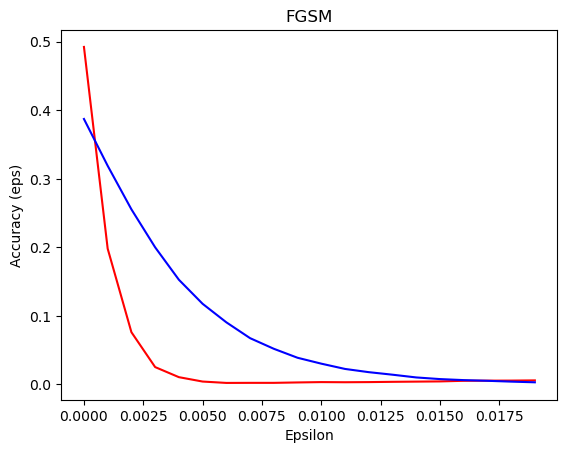

In [16]:
def plot_all_attacks(attack):
    for i in range(100):
        mbp, mll = load_trained_models(i)
        AdamOpt_ll = Adam(mll.parameters(), lr=LEARNING_RATE)
        AdamOpt_bp = Adam(mbp.parameters(), lr=LEARNING_RATE)
        plot_attack(mbp,mll,attack,AdamOpt_bp, AdamOpt_ll)

    plt.show()
    
plot_all_attacks(FGSM)